In [7]:
import pandas as pd
import sklearn.datasets as data

In [8]:
# Load dataset
df_titanic = pd.read_csv(r'C:\Users\marku\Desktop\Skole\5\ML\MLGit\datasets\titanic.csv')
df_titanic_test = pd.read_csv(r'C:\Users\marku\Desktop\Skole\5\ML\MLGit\datasets\test_titanic.csv')

In [9]:
df_titanic = df_titanic.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

In [10]:
# Sets null values equal to the median of that column
def handle_null_median(df):
    # Need to set inplace=True, so it doesn't create a copy of the dataframe. Tried without and this led to null-values not being removed
    df['Fare'].fillna(df['Fare'].median(), inplace=True)
    df['Age'].fillna(df['Age'].median(), inplace=True)

    df['Embarked'].fillna('S', inplace=True)

    return  df

df_titanic = handle_null_median(df_titanic)

In [11]:
df_titanic['Sex'] = df_titanic['Sex'].replace(['female', 'male'], [0,1])

In [12]:
df_titanic['FamilyMembersCount'] = df_titanic['Parch'] + df_titanic['SibSp'] + 1

In [13]:
df_XGB = df_titanic.copy()
df_RF = df_titanic.copy()
df_GNB = df_titanic.copy()

In [14]:
def bins(df): # This is kind of feature engineering as well
    df['AgeGroup'] = 0
    df.loc[df['Age'] < 16.336, 'AgeGroup' ] = 0
    df.loc[(df['Age'] >= 16.336) & (df['Age'] < 32.252), 'AgeGroup'] = 1
    df.loc[(df['Age'] >= 32.252) & (df['Age'] < 48.168), 'AgeGroup'] = 2
    df.loc[(df['Age'] >= 48.168) & (df['Age'] < 64.084), 'AgeGroup'] = 3
    df.loc[df['Age'] >= 64.084, 'AgeGroup'] = 4

    # Could also create bins for fare, but not sure Fare is needed.
    return df

df_XGB = bins(df_titanic)
df_XGB

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilyMembersCount,AgeGroup
0,0,3,1,22.0,1,0,7.2500,S,2,1
1,1,1,0,38.0,1,0,71.2833,C,2,2
2,1,3,0,26.0,0,0,7.9250,S,1,1
3,1,1,0,35.0,1,0,53.1000,S,2,2
4,0,3,1,35.0,0,0,8.0500,S,1,2
...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,13.0000,S,1,1
887,1,1,0,19.0,0,0,30.0000,S,1,1
888,0,3,0,28.0,1,2,23.4500,S,4,1
889,1,1,1,26.0,0,0,30.0000,C,1,1


In [15]:
df_titanic['Pclass'] =  df_titanic['Pclass'].astype('category')
df_titanic['Embarked'] =  df_titanic['Embarked'].astype('category')
df_titanic['AgeGroup'] =  df_titanic['AgeGroup'].astype('category')

In [16]:
df_XGB = pd.get_dummies(df_titanic)
df_RF = pd.get_dummies(df_titanic)
df_GNB = pd.get_dummies(df_titanic)

In [17]:
from sklearn.model_selection import train_test_split

# XGBoost

In [18]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

train_X, test_X, train_y, test_y = train_test_split(df_XGB.drop('Survived', axis=1), df_XGB['Survived'], random_state=0)

model = XGBClassifier()
model.fit(train_X, train_y)

pred_y = model.predict(test_X)
preds = [round(value) for value in pred_y]

# evaluate predictions
accuracy = accuracy_score(test_y, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

array([0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 1])

In [19]:
from sklearn.model_selection import GridSearchCV
XGBParam = {"subsample":[0.5, 0.75, 1],
              "colsample_bytree":[0.5, 0.75, 1],
              "max_depth":[2, 6, 12],
              "min_child_weight":[1,5,15],
              "learning_rate":[0.3, 0.1, 0.03],
              "n_estimators":[100]}

XGB_grid = GridSearchCV(XGBClassifier(), XGBParam)
XGB_grid.fit(train_X, train_y)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     n

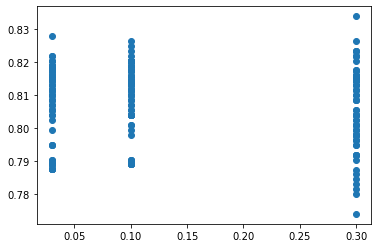

In [20]:
gb_results = pd.DataFrame(XGB_grid.cv_results_)

import matplotlib.pyplot as plt

plt.scatter(gb_results['param_learning_rate'], gb_results['mean_test_score'])

In [21]:
print(XGB_grid.best_score_)

0.8338233643811019


In [22]:
print(XGB_grid.best_params_)

{'colsample_bytree': 0.5, 'learning_rate': 0.3, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.5}


# Random Forrest Classifier

In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

train_X, test_X, train_y, test_y = train_test_split(df_RF.drop('Survived', axis=1), df_RF['Survived'], random_state=0)

# Train and test random forest classifier with default parameters
rf_scores = cross_val_score(RandomForestClassifier(), train_X, train_y)
(rf_scores.mean(), rf_scores.std())

(0.7934126360677813, 0.027878884782681034)

# GaussianNB

In [24]:
from sklearn.naive_bayes import GaussianNB

train_X, test_X, train_y, test_y = train_test_split(df_RF.drop('Survived', axis=1), df_RF['Survived'], random_state=0)

# Train and test random forest classifier with default parameters
GNB_scores = cross_val_score(GaussianNB(), train_X, train_y)
(GNB_scores.mean(), GNB_scores.std())

(0.6948378408708338, 0.12828892886036422)